In [1]:
## Libraries to include
library(tidyverse)
library(lubridate)
# For Veil of Darkness
library(lutz)
library(suncalc)
library(splines2)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.0.0     v purrr   0.3.2
v tibble  1.4.2     v dplyr   0.7.6
v tidyr   0.8.1     v stringr 1.4.0
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



# Ryan Metro Code Starts Here

In [45]:
# Logistic regression

# Make dummy data sets with one row per stop/search

stops <- data.frame(
  race = c(
    rep('asian', 205),
    rep('black', 14201),
    rep('latino', 13550),
    rep('middleeast', 503),
    rep('nativeind', 12),
    rep('pacific', 56),
    rep('white', 1593),
    rep('multi', 193)
  ),
  searched = c(
    rep(1, 53), rep(0, 152),
    rep(1, 6662), rep(0, 7539),
    rep(1, 6602), rep(0, 6948),
    rep(1, 215), rep(0, 288),
    rep(1, 5), rep(0, 7),
    rep(1, 26), rep(0, 30),
    rep(1, 619), rep(0, 974),
    rep(1, 101), rep(0, 92)  
      
  ),
  stringsAsFactors = FALSE
)

searches <- data.frame(
  race = c(
    rep('asian', 53),
    rep('black', 6662),
    rep('latino', 6602),
    rep('middleeast', 215),
    rep('nativeind', 5),
    rep('pacific', 26),
    rep('white', 619),
    rep('multi', 101)
  ),
  contraband = c(
    rep(1, 8), rep(0, 45),
    rep(1, 1216), rep(0, 5446),
    rep(1, 1223), rep(0, 5379),
    rep(1, 32), rep(0, 183),
    rep(1, 1), rep(0, 4),
    rep(1, 6), rep(0, 20),
    rep(1, 109), rep(0, 510),
    rep(1, 9), rep(0, 92)
  ),
  stringsAsFactors = FALSE
)

In [46]:
# Fewer race categories

race4 <- tribble(
  ~race, ~race4,
  'asian','other',
  'black','black',
  'latino','latino',
  'nativeind','other',
  'middleeast','other',
  'pacific','other',
  'multi','other',
  'white','a_white'
)

stops <- stops %>% left_join(race4)
searches <- searches %>% left_join(race4)

#Sums to ensure the data was entered correctly

stops %>% group_by(race) %>% summarise(n())

stops %>% group_by(race, searched) %>% summarise(n())

stops %>% group_by(race4, searched) %>% summarise(n())

Joining, by = "race"
Joining, by = "race"


race,n()
asian,205
black,14201
latino,13550
middleeast,503
multi,193
nativeind,12
pacific,56
white,1593


race,searched,n()
asian,0,152
asian,1,53
black,0,7539
black,1,6662
latino,0,6948
latino,1,6602
middleeast,0,288
middleeast,1,215
multi,0,92
multi,1,101


race4,searched,n()
a_white,0,974
a_white,1,619
black,0,7539
black,1,6662
latino,0,6948
latino,1,6602
other,0,569
other,1,400


In [47]:
### Odds of search at a stop

stopmodel <- glm(searched ~ race4, data = stops, family = "binomial")
summary(stopmodel)


#Latino coefficient is the only one that is significant.

#Get the odds ratio by exponentiating the coefficients of the model

stopor <- exp(data.frame(OR=coef(stopmodel), confint(stopmodel)))
stopor

#Latinos have more than XXX times the *odds* of getting searched at a traffic stop in these data 
# might be easier to explain with risk ratio



Call:
glm(formula = searched ~ race4, family = "binomial", data = stops)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1558  -1.1254  -0.9919   1.2304   1.3750  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.45331    0.05140  -8.819  < 2e-16 ***
race4black   0.32964    0.05408   6.095 1.09e-09 ***
race4latino  0.40222    0.05420   7.421 1.16e-13 ***
race4other   0.10089    0.08306   1.215    0.225    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 41922  on 30312  degrees of freedom
Residual deviance: 41850  on 30309  degrees of freedom
AIC: 41858

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...


,OR,X2.5..,X97.5..
(Intercept),0.6355236,0.5743868,0.7026368
race4black,1.3904622,1.2510172,1.5465021
race4latino,1.4951474,1.3448950,1.6633143
race4other,1.1061551,0.9397974,1.3015715


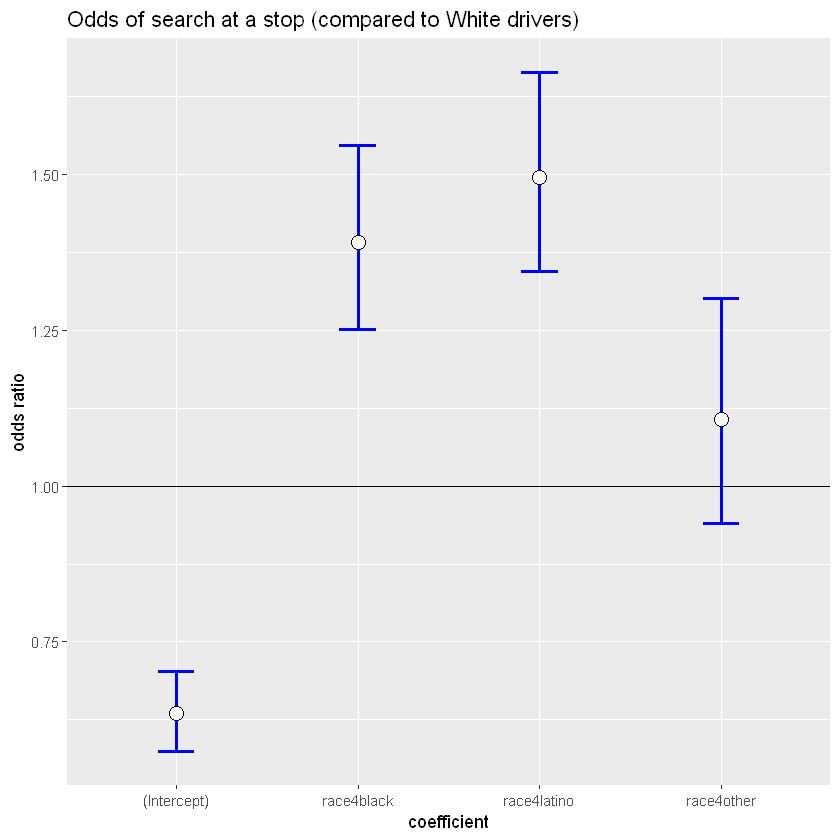

In [50]:
# Plot
ggplot() + 
  geom_errorbar(
    mapping=aes(x=row.names(stopor),ymin=stopor[,'X97.5..'],ymax=stopor[,'X2.5..']),
    width=0.2,
    size=1,
    color="blue"
  ) + 
  geom_point(
    mapping=aes(x=row.names(stopor), y=stopor[,'OR']),
    size=4,
    shape=21,
    fill="white"
  ) +
  geom_hline(yintercept=1) +
  labs(x='coefficient',y='odds ratio',title='Odds of search at a stop (compared to White drivers)')


Call:
glm(formula = contraband ~ race4, family = "binomial", data = searches)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6401  -0.6401  -0.6349  -0.6349   1.9830  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.54306    0.10552 -14.623   <2e-16 ***
race4black   0.04375    0.11019   0.397    0.691    
race4latino  0.06187    0.11018   0.562    0.574    
race4other  -0.27223    0.17860  -1.524    0.127    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 13566  on 14282  degrees of freedom
Residual deviance: 13560  on 14279  degrees of freedom
AIC: 13568

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...


,OR,X2.5..,X97.5..
(Intercept),0.2137255,0.1729550,0.2616728
race4black,1.0447193,0.8451821,1.3022926
race4latino,1.0638211,0.8606552,1.3260771
race4other,0.7616812,0.5339118,1.0765727


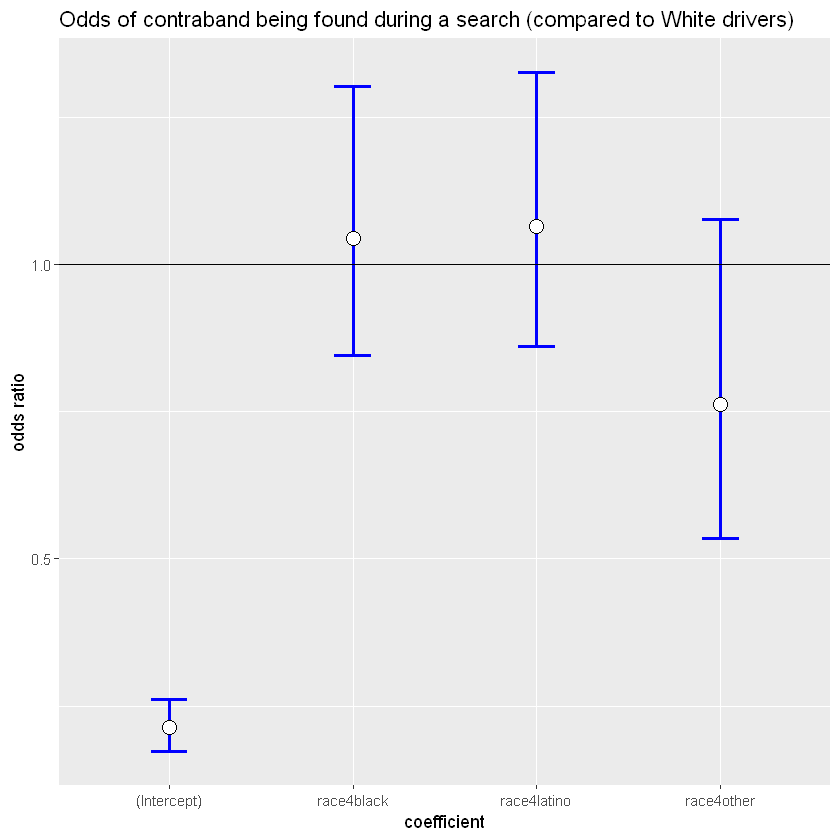

In [51]:
# In this plot, the intercept can be safely ignored. 
# The reference group here is Other Race drivers, because it appears alphabetically first. 
# The confidence interval for Blacks and Latinos is far above 1. 
# If it were to contain 1, as the white and other groups do,
#it would indicate no statistically signifcant difference with the black drivers. 
# It's clear that the odds of Latinos getting searched is much higher than the rest of the population.

# Odds of contraband found during a search

searchmodel <- glm(contraband ~ race4, data = searches, family = "binomial")
summary(searchmodel)

searchor <- exp(data.frame(OR=coef(searchmodel), confint(searchmodel)))
searchor

ggplot() + 
  geom_errorbar(
    mapping=aes(x=row.names(searchor),ymin=searchor[,'X97.5..'],ymax=searchor[,'X2.5..']),
    width=0.2,
    size=1,
    color="blue"
  ) + 
  geom_point(
    mapping=aes(x=row.names(searchor), y=searchor[,'OR']),
    size=4,
    shape=21,
    fill="white"
  ) +
  geom_hline(yintercept=1) +
  labs(x='coefficient',y='odds ratio',title='Odds of contraband being found during a search (compared to White drivers)')

#Here the Latino and white confidence intervals both capture the value 1, indicating there is not a significant difference in the odds of Latinos, whites and blacks when it comes to contraband turning up during searches.

# The "other" group seems to be significantly higher than blacks, though the really wide confidence interval indicates a lot of variation. This could be because the 37 unknowns are all treated as if there was contraband found during the search.

# ALL LAPD Stop Analysis

In [40]:
# Logistic regression

# Make dummy data sets with one row per stop/search

stops <- data.frame(
  race = c(
    rep('asian', 11403),
    rep('black', 81615),
    rep('latino', 142829),
    rep('middleeast', 11112),
    rep('nativeind', 194),
    rep('pacific', 810),
    rep('white', 52807),
    rep('multi', 2162)
  ),
  searched = c(
    rep(1, 249), rep(0, 11154),
    rep(1, 19355), rep(0, 62260),
    rep(1, 23724), rep(0, 119105),
    rep(1, 557), rep(0, 10555),
    rep(1, 43), rep(0, 151),
    rep(1, 66), rep(0, 744),
    rep(1, 2777), rep(0, 50030),
    rep(1, 340), rep(0, 1822)  
      
  ),
  stringsAsFactors = FALSE
)

searches <- data.frame(
  race = c(
    rep('asian', 249),
    rep('black', 19355),
    rep('latino', 23724),
    rep('middleeast', 557),
    rep('nativeind', 43),
    rep('pacific', 66),
    rep('white', 2777),
    rep('multi', 340)
  ),
  contraband = c(
    rep(1, 48), rep(0, 201),
    rep(1, 3374), rep(0, 15981),
    rep(1, 3790), rep(0, 19934),
    rep(1, 91), rep(0, 466),
    rep(1, 4), rep(0, 39),
    rep(1, 15), rep(0, 51),
    rep(1, 578), rep(0, 2199),
    rep(1, 47), rep(0, 293)
  ),
  stringsAsFactors = FALSE
)

In [41]:
# Fewer race categories

race4 <- tribble(
  ~race, ~race4,
  'asian','other',
  'black','black',
  'latino','latino',
  'nativeind','other',
  'middleeast','other',
  'pacific','other',
  'multi','other',
  'white','a_white'
)

stops <- stops %>% left_join(race4)
searches <- searches %>% left_join(race4)

#Sums to ensure the data was entered correctly

stops %>% group_by(race) %>% summarise(n())

stops %>% group_by(race, searched) %>% summarise(n())

stops %>% group_by(race4, searched) %>% summarise(n())

Joining, by = "race"
Joining, by = "race"


race,n()
asian,11403
black,81615
latino,142829
middleeast,11112
multi,2162
nativeind,194
pacific,810
white,52807


race,searched,n()
asian,0,11154
asian,1,249
black,0,62260
black,1,19355
latino,0,119105
latino,1,23724
middleeast,0,10555
middleeast,1,557
multi,0,1822
multi,1,340


race4,searched,n()
a_white,0,50030
a_white,1,2777
black,0,62260
black,1,19355
latino,0,119105
latino,1,23724
other,0,24426
other,1,1255


In [42]:
### Odds of search at a stop

stopmodel <- glm(searched ~ race4, data = stops, family = "binomial")
summary(stopmodel)


#Latino coefficient is the only one that is significant.

#Get the odds ratio by exponentiating the coefficients of the model

stopor <- exp(data.frame(OR=coef(stopmodel), confint(stopmodel)))
stopor

#Latinos have more than XXX times the *odds* of getting searched at a traffic stop in these data 
# might be easier to explain with risk ratio



Call:
glm(formula = searched ~ race4, family = "binomial", data = stops)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7358  -0.6027  -0.6027  -0.3287   2.4571  

Coefficients:
            Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -2.89125    0.01950 -148.306   <2e-16 ***
race4black   1.72288    0.02116   81.418   <2e-16 ***
race4latino  1.27773    0.02075   61.574   <2e-16 ***
race4other  -0.07726    0.03490   -2.214   0.0268 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 261830  on 302931  degrees of freedom
Residual deviance: 249647  on 302928  degrees of freedom
AIC: 249655

Number of Fisher Scoring iterations: 5


Waiting for profiling to be done...


,OR,X2.5..,X97.5..
(Intercept),0.0555067,0.0534140,0.05765622
race4black,5.6006532,5.3740793,5.83890078
race4latino,3.5884966,3.4461204,3.73817518
race4other,0.9256483,0.8642178,0.99091927


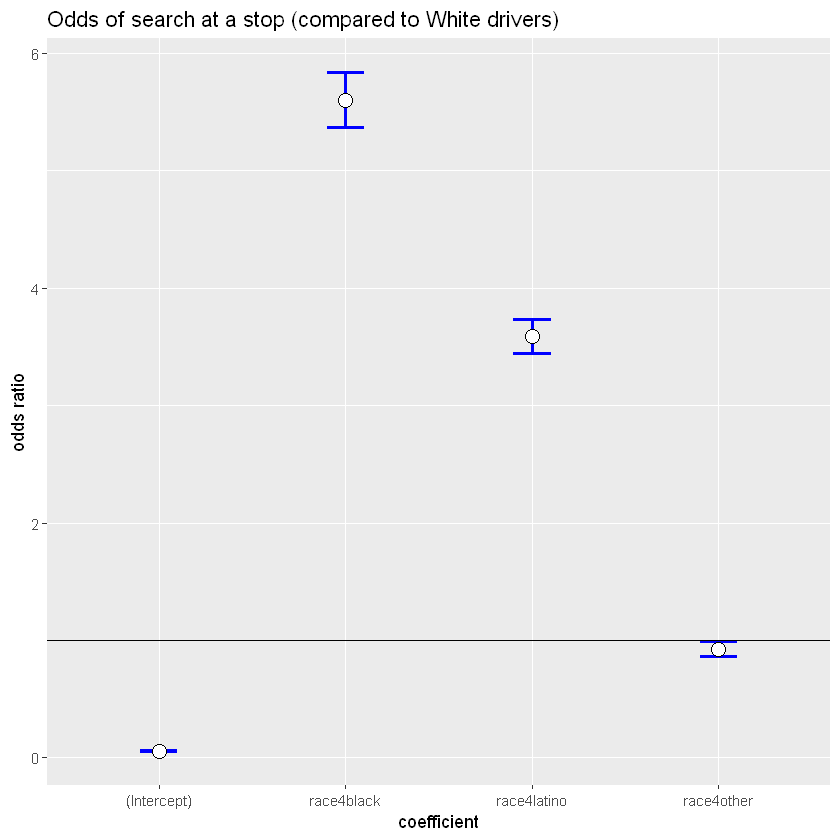

In [43]:
# Plot
ggplot() + 
  geom_errorbar(
    mapping=aes(x=row.names(stopor),ymin=stopor[,'X97.5..'],ymax=stopor[,'X2.5..']),
    width=0.2,
    size=1,
    color="blue"
  ) + 
  geom_point(
    mapping=aes(x=row.names(stopor), y=stopor[,'OR']),
    size=4,
    shape=21,
    fill="white"
  ) +
  geom_hline(yintercept=1) +
  labs(x='coefficient',y='odds ratio',title='Odds of search at a stop (compared to White drivers)')


Call:
glm(formula = contraband ~ race4, family = "binomial", data = searches)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6832  -0.6190  -0.5900  -0.5900   1.9153  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.33618    0.04674 -28.586  < 2e-16 ***
race4black  -0.21912    0.05044  -4.344 1.40e-05 ***
race4latino -0.32388    0.04999  -6.479 9.23e-11 ***
race4other  -0.29735    0.08953  -3.321 0.000896 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 42758  on 47110  degrees of freedom
Residual deviance: 42710  on 47107  degrees of freedom
AIC: 42718

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...


,OR,X2.5..,X97.5..
(Intercept),0.2628467,0.2396362,0.2878342
race4black,0.8032274,0.7281081,0.8873053
race4latino,0.7233394,0.6562776,0.7983679
race4other,0.7427830,0.6221893,0.8838999


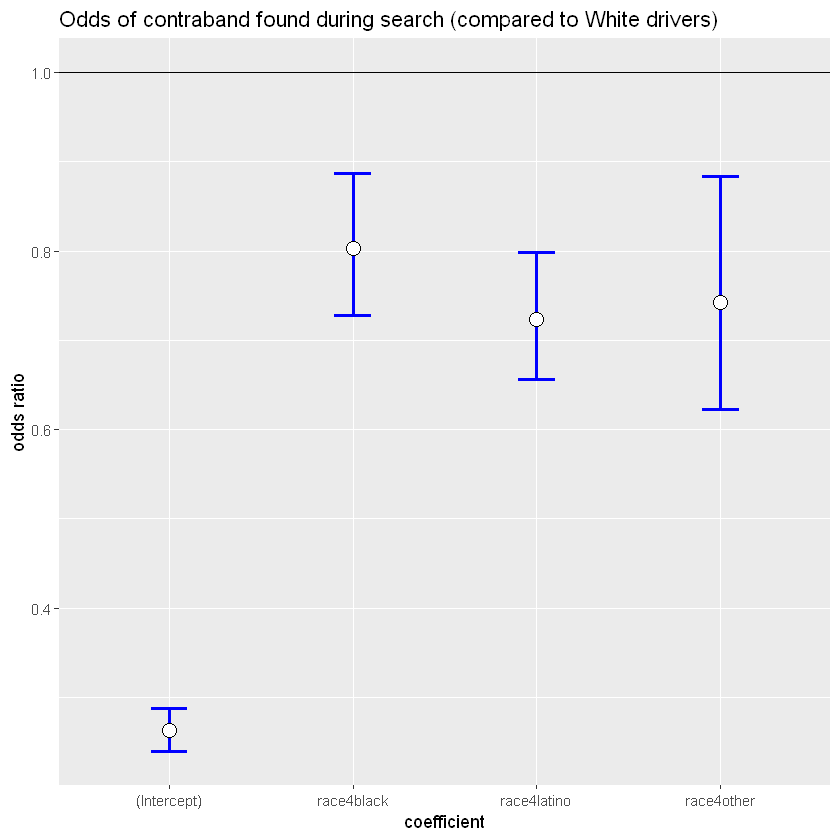

In [44]:
# Odds of contraband found during a search

searchmodel <- glm(contraband ~ race4, data = searches, family = "binomial")
summary(searchmodel)

searchor <- exp(data.frame(OR=coef(searchmodel), confint(searchmodel)))
searchor

ggplot() + 
  geom_errorbar(
    mapping=aes(x=row.names(searchor),ymin=searchor[,'X97.5..'],ymax=searchor[,'X2.5..']),
    width=0.2,
    size=1,
    color="blue"
  ) + 
  geom_point(
    mapping=aes(x=row.names(searchor), y=searchor[,'OR']),
    size=4,
    shape=21,
    fill="white"
  ) +
  geom_hline(yintercept=1) +
  labs(x='coefficient', y='odds ratio', title='Odds of contraband found during search (compared to White drivers)')

# ALL LAPD Stop Analysis - Exclude Probation Stops

In [35]:
# Logistic regression

# Make dummy data sets with one row per stop/search

stops <- data.frame(
  race = c(
    rep('asian', 11155),
    rep('black', 74774),
    rep('latino', 134787),
    rep('middleeast', 10922),
    rep('nativeind', 187),
    rep('pacific', 797),
    rep('white', 51154),
    rep('multi', 2053)
  ),
  searched = c(
    rep(1, 213), rep(0, 10942),
    rep(1, 13071), rep(0, 61703),
    rep(1, 18008), rep(0, 116779),
    rep(1, 449), rep(0, 10473),
    rep(1, 36), rep(0, 151),
    rep(1, 58), rep(0, 739),
    rep(1, 2173), rep(0, 48981),
    rep(1, 249), rep(0, 1804)  
      
  ),
  stringsAsFactors = FALSE
)

searches <- data.frame(
  race = c(
    rep('asian', 213),
    rep('black', 13071),
    rep('latino', 18008),
    rep('middleeast', 449),
    rep('nativeind', 36),
    rep('pacific', 58),
    rep('white', 2173),
    rep('multi', 249)
  ),
  contraband = c(
    rep(1, 41), rep(0, 172),
    rep(1, 2575), rep(0, 10496),
    rep(1, 3108), rep(0, 14900),
    rep(1, 83), rep(0, 366),
    rep(1, 4), rep(0, 32),
    rep(1, 14), rep(0, 44),
    rep(1, 469), rep(0, 1704),
    rep(1, 39), rep(0, 210)
  ),
  stringsAsFactors = FALSE
)

In [36]:
# Fewer race categories

race4 <- tribble(
  ~race, ~race4,
  'asian','other',
  'black','black',
  'latino','latino',
  'nativeind','other',
  'middleeast','other',
  'pacific','other',
  'multi','other',
  'white','a_white'
)

stops <- stops %>% left_join(race4)
searches <- searches %>% left_join(race4)

#Sums to ensure the data was entered correctly

stops %>% group_by(race) %>% summarise(n())

stops %>% group_by(race, searched) %>% summarise(n())

stops %>% group_by(race4, searched) %>% summarise(n())

Joining, by = "race"
Joining, by = "race"


race,n()
asian,11155
black,74774
latino,134787
middleeast,10922
multi,2053
nativeind,187
pacific,797
white,51154


race,searched,n()
asian,0,10942
asian,1,213
black,0,61703
black,1,13071
latino,0,116779
latino,1,18008
middleeast,0,10473
middleeast,1,449
multi,0,1804
multi,1,249


race4,searched,n()
a_white,0,48981
a_white,1,2173
black,0,61703
black,1,13071
latino,0,116779
latino,1,18008
other,0,24109
other,1,1005


In [37]:
### Odds of search at a stop

stopmodel <- glm(searched ~ race4, data = stops, family = "binomial")
summary(stopmodel)


#Latino coefficient is the only one that is significant.

#Get the odds ratio by exponentiating the coefficients of the model

stopor <- exp(data.frame(OR=coef(stopmodel), confint(stopmodel)))
stopor

#Latinos have more than XXX times the *odds* of getting searched at a traffic stop in these data 
# might be easier to explain with risk ratio



Call:
glm(formula = searched ~ race4, family = "binomial", data = stops)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6199  -0.5356  -0.5356  -0.2947   2.5371  

Coefficients:
            Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -3.11532    0.02192 -142.129   <2e-16 ***
race4black   1.56339    0.02394   65.303   <2e-16 ***
race4latino  1.24586    0.02334   53.389   <2e-16 ***
race4other  -0.06227    0.03894   -1.599     0.11    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 209586  on 285828  degrees of freedom
Residual deviance: 201714  on 285825  degrees of freedom
AIC: 201722

Number of Fisher Scoring iterations: 5


Waiting for profiling to be done...


,OR,X2.5..,X97.5..
(Intercept),0.04436414,0.04248621,0.04629896
race4black,4.77496757,4.55709593,5.00555991
race4latino,3.47591079,3.32130024,3.63950425
race4other,0.93962556,0.87026985,1.01384210


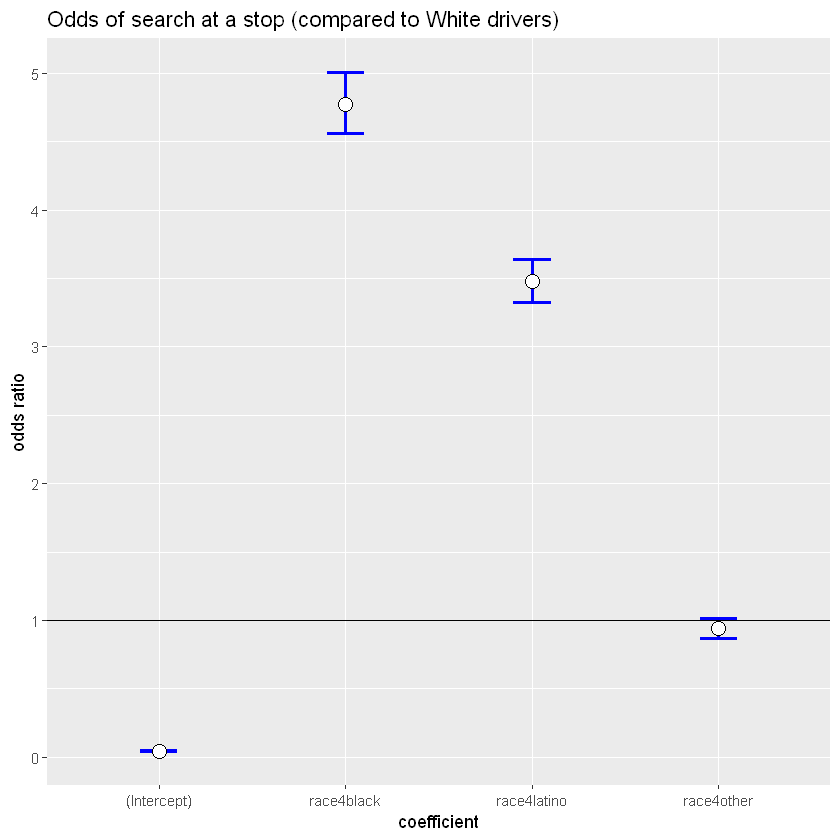

In [38]:
# Plot
ggplot() + 
  geom_errorbar(
    mapping=aes(x=row.names(stopor),ymin=stopor[,'X97.5..'],ymax=stopor[,'X2.5..']),
    width=0.2,
    size=1,
    color="blue"
  ) + 
  geom_point(
    mapping=aes(x=row.names(stopor), y=stopor[,'OR']),
    size=4,
    shape=21,
    fill="white"
  ) +
  geom_hline(yintercept=1) +
  labs(x='coefficient',y='odds ratio',title='Odds of search at a stop (compared to White drivers)')


Call:
glm(formula = contraband ~ race4, family = "binomial", data = searches)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6973  -0.6624  -0.6156  -0.6156   1.8745  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.29013    0.05214 -24.741  < 2e-16 ***
race4black  -0.11501    0.05659  -2.032   0.0421 *  
race4latino -0.27725    0.05575  -4.973 6.58e-07 ***
race4other  -0.22554    0.09725  -2.319   0.0204 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 32797  on 34256  degrees of freedom
Residual deviance: 32753  on 34253  degrees of freedom
AIC: 32761

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...


,OR,X2.5..,X97.5..
(Intercept),0.2752347,0.2482427,0.3045573
race4black,0.8913539,0.7984030,0.9967461
race4latino,0.7578644,0.6799797,0.8461018
race4other,0.7980831,0.6584089,0.9641293


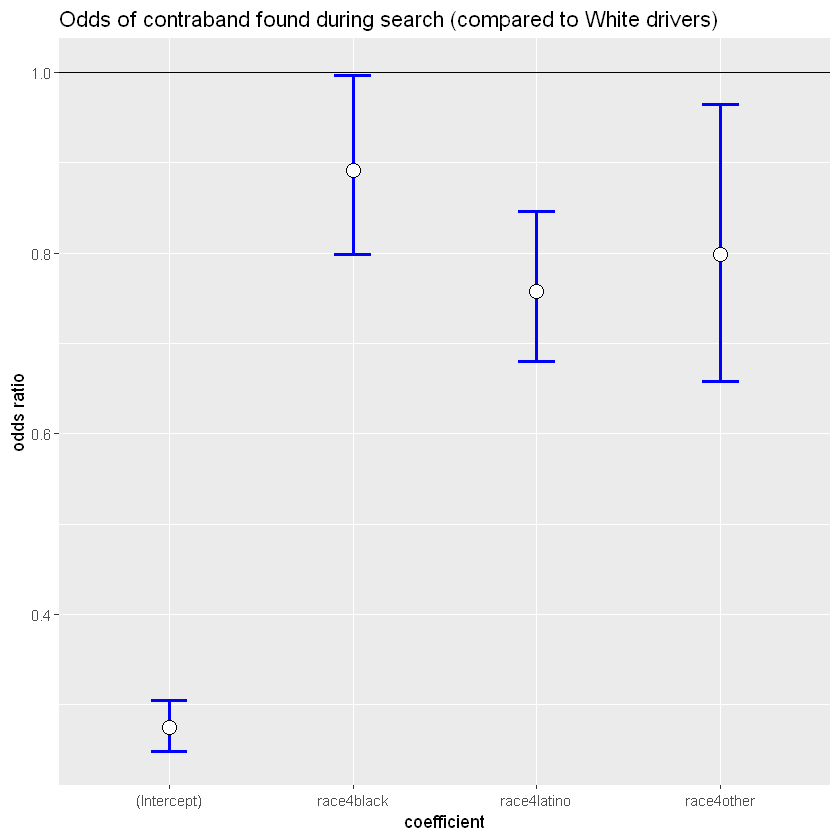

In [39]:
# Odds of contraband found during a search

searchmodel <- glm(contraband ~ race4, data = searches, family = "binomial")
summary(searchmodel)

searchor <- exp(data.frame(OR=coef(searchmodel), confint(searchmodel)))
searchor

ggplot() + 
  geom_errorbar(
    mapping=aes(x=row.names(searchor),ymin=searchor[,'X97.5..'],ymax=searchor[,'X2.5..']),
    width=0.2,
    size=1,
    color="blue"
  ) + 
  geom_point(
    mapping=aes(x=row.names(searchor), y=searchor[,'OR']),
    size=4,
    shape=21,
    fill="white"
  ) +
  geom_hline(yintercept=1) +
  labs(x='coefficient', y='odds ratio', title='Odds of contraband found during search (compared to White drivers)')